In [1]:
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# (함수) DataFrame으로 불러오는 함수

In [2]:
import pandas as pd

In [3]:
def openDataFrame(path):
    return pd.read_csv(path, on_bad_lines='skip', encoding = "ISO-8859-1")

# 0. 원본 데이터 :  Wine Quality Prediction Analysis - Classification

In [4]:
path_wine = './winequality.csv'

In [5]:
df_wine = openDataFrame(path_wine)
df_wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# 1. 전처리기(나만의 변환기들)

In [6]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

## 1.1 변환기: Type 이진화

In [7]:
class TypeBinaryConverter(BaseEstimator, TransformerMixin):
    def __init__(self, name='type'):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.name] = (X[self.name] == 'white').astype(int)
        return X

## 1.2 변환기: quality 3->4, 9->8 변환

In [8]:
class MergeQuality(BaseEstimator, TransformerMixin):
    def __init__(self, name='quality'):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.name] = X[self.name].replace({3:4, 9:8})
        return X

## 1.3 변환기: quality 4, ... ,8 이진그룹화 변환

In [9]:
class QualityGroups(BaseEstimator, TransformerMixin):
    def __init__(self, listGroups=['quality_4', 'quality_5', 'quality_6', 'quality_7', 'quality_8']):
        self.listGroups = listGroups
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for i, name in enumerate(self.listGroups):
            X[name] = (X['quality']==i+4).astype(int)
        return X

## 1.4 변환기: 특성들의 극단치 모두 제거

In [10]:
class DropOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, scope=5):
        self.scope = scope
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        myList = []
        for name in X.columns:
            if name not in ['type', 'quality']:
                Q1 = X[[name]].quantile(0.25)
                Q3 = X[[name]].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.scope * IQR
                upper_bound = Q3 + self.scope * IQR

                # 극단치가 있는 열과 행을 찾음
                outlier_cols = np.where((X[[name]] < lower_bound) | (X[[name]] > upper_bound))[1]
                outlier_rows = np.where((X[[name]] < lower_bound) | (X[[name]] > upper_bound))[0]

                # 극단치가 있는 행의 인덱스를 반환
                outlier_indices = pd.Series(outlier_rows).unique()    
                myList += list(outlier_indices)
        newDf = X.copy().drop(myList, axis=0)
        return newDf

## 1.5 변환기: log_scaler

In [11]:
import numpy as np

class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self, listNames=['chlorides', 'residual sugar']):
        self.listNames = listNames
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for name in self.listNames:
            X[name] = [np.log(x+1) for x in list(X[name])]
        return X

In [12]:
# logScaler = LogScaler()
# logScaler.transform(df_wine.iloc[:, 1:])

## 1.6 KNN이용한 결측치 채우기

In [13]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

## 1.7 DataFrame 포맷으로 되돌리기

In [14]:
class FormatDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, column_names=['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality','quality_4','quality_5','quality_6','quality_7','quality_8']):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.column_names)

# 2. 전처리 파이프라인 구성

## 2.1 Pipeline을 이용한 전처리 작동 코드

In [15]:
from sklearn.pipeline import Pipeline

preproc_pipeline = Pipeline([
    ('binary_type', TypeBinaryConverter()), # type변수를 0,1 binary화
    ('drop_outliers', DropOutliers(scope=5)), # 이상치 제거
    ('merge_quality', MergeQuality()), # quality변수 3->4, 9->8 변환
    ('quality_groups', QualityGroups()), # quality변수 one-hot encode(binary 모델 구축을 위한)
    ('log_scaler', LogScaler()), # log정규화
    ('knn_imputer', KNNImputer(n_neighbors=2, weights="uniform")), # 결측치 KNN 메꾸기
    ('format_dataframe', FormatDataFrame()) # 데이터프레임으로 재정의
])

# 각단계 전처리를 끄고 싶으면(하지 않고 싶으면), 각 라인을 주석처리하면 됨.
# 예를 들어, 두 번째 줄 ('drop_outliers', DropOutliers(scope=5))을 주석처리하면 극단치 제거가 되지 않음.

In [16]:
# 다음과 같이 일반적인 estimator처럼 fit_transform() 메소드로 전처리 가능
df_preproc = preproc_pipeline.fit_transform(df_wine.copy())

# 3. 전처리된 데이터프레임으로 작업하기

In [17]:
# 전처리된 데이터프레임 호출
df_preproc

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_4,quality_5,quality_6,quality_7,quality_8
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.45,8.8,6.0,0.0,0.0,1.0,0.0,0.0
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.49,9.5,6.0,0.0,0.0,1.0,0.0,0.0
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.44,10.1,6.0,0.0,0.0,1.0,0.0,0.0
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,0.0,1.0,0.0,0.0,0.0
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.93,11.2,6.0,0.0,0.0,1.0,0.0,0.0
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,0.0,0.0,1.0,0.0,0.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,0.0,1.0,0.0,0.0,0.0


In [22]:
p=df_preproc.iloc[1:,:]
p

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_4,quality_5,quality_6,quality_7,quality_8
1,1.0,6.3,0.30,0.34,0.955511,0.047837,14.0,132.0,0.9940,3.30,0.49,9.5,6.0,0.0,0.0,1.0,0.0,0.0
2,1.0,8.1,0.28,0.40,2.066863,0.048790,30.0,97.0,0.9951,3.26,0.44,10.1,6.0,0.0,0.0,1.0,0.0,0.0
3,1.0,7.2,0.23,0.32,2.251292,0.056380,47.0,186.0,0.9956,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
4,1.0,7.2,0.23,0.32,2.251292,0.056380,47.0,186.0,0.9956,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0


In [19]:
# 이렇게 하면 X
X = df_preproc.iloc[:, :-6]
X

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.45,8.8
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.49,9.5
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.44,10.1
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.58,10.5
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.93,11.2
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.75,11.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.71,10.2


In [20]:
# 이렇게 하면 quality_6의 목적변수
# y_6 = df_preproc[['quality_6']]
for i in range(4, 9):
    column_name = 'quality_' + str(i)
    globals()['y_'+str(i)] = df_preproc[[column_name]]

# 4. Random Forest classfication

## 4.1 training-validation-test seperation

In [21]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# # 데이터셋을 트레이닝 셋과 임시 셋으로 60:40 비율로 나눔
# X_train, X_tmp, y_4_train, y_4_tmp = train_test_split(X, y_4, test_size=0.4, random_state=100)
# # oversampling(ros), undersampling(rus)
# ros = SMOTE(k_neighbors=4)
# X_train_ros, y_4_train_ros = ros.fit_resample(X_train, y_4_train)
# rus = RandomUnderSampler(random_state=100)
# X_train_rus, y_4_train_rus = rus.fit_resample(X_train, y_4_train)
# # 임시 셋을 밸리데이션 셋과 테스트 셋으로 50:50 비율로 나눔
# X_val, X_test, y_4_val, y_4_test = train_test_split(X_tmp, y_4_tmp, test_size=0.5, random_state=100)

for i in range(4, 9):
    column_name = 'quality_' + str(i)
    globals()['y_'+str(i)] = df_preproc[[column_name]]
    # 데이터셋을 트레이닝 셋과 임시 셋으로 60:40 비율로 나눔
    globals()['X_'+str(i)+'_train'], globals()['X_'+str(i)+'_tmp'], globals()['y_'+str(i)+'_train'], globals()['y_'+str(i)+'_tmp'] = train_test_split(X, globals()['y_'+str(i)], test_size=0.4, random_state=100)
    # oversampling(ros), undersampling(rus)
    ros = SMOTE(k_neighbors=4)
    globals()['X_'+str(i)+'_train_ros'], globals()['y_'+str(i)+'_train_ros'] = ros.fit_resample(globals()['X_'+str(i)+'_train'], globals()['y_'+str(i)+'_train'])
    rus = RandomUnderSampler(random_state=100)
    globals()['X_'+str(i)+'_train_rus'], globals()['y_'+str(i)+'_train_rus'] = rus.fit_resample(globals()['X_'+str(i)+'_train'], globals()['y_'+str(i)+'_train'])
    # 임시 셋을 밸리데이션 셋과 테스트 셋으로 50:50 비율로 나눔
    globals()['X_'+str(i)+'_val'], globals()['X_'+str(i)+'_test'], globals()['y_'+str(i)+'_val'], globals()['y_'+str(i)+'_test'] = train_test_split(globals()['X_'+str(i)+'_tmp'], globals()['y_'+str(i)+'_tmp'], test_size=0.5, random_state=100)
    

## 4.2 GridSearch

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import make_scorer

for i in range(4, 9):
    # 랜덤 포레스트 (멀티클래스) 모델 정의
    rnf_orign = RandomForestClassifier()
    rnf_ros = RandomForestClassifier()
    rnf_rus = RandomForestClassifier()

    # 탐색할 파라미터 그리드 정의
    param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [100]
    }

    # 그리드 서치 객체 생성
    grid_search_orign = GridSearchCV(rnf_orign, param_grid=[param_grid], cv=5, n_jobs=-1, scoring='f1')
    grid_search_ros = GridSearchCV(rnf_ros, param_grid=[param_grid], cv=5, n_jobs=-1, scoring='f1')
    grid_search_rus = GridSearchCV(rnf_rus, param_grid=[param_grid], cv=5, n_jobs=-1, scoring='f1')

    # 그리드 서치 수행
    grid_search_orign.fit(globals()['X_'+str(i)+'_train'], globals()['y_'+str(i)+'_train'])
    grid_search_ros.fit(globals()['X_'+str(i)+'_train_ros'], globals()['y_'+str(i)+'_train_ros'])
    grid_search_rus.fit(globals()['X_'+str(i)+'_train_rus'], globals()['y_'+str(i)+'_train_rus'])

    # 최적 파라미터와 점수 출력
    print('y_' + str(i) + ' Grid Search (f1 score / default_F)')
    print('-------------------------------------------------------------------------------------------------------------------')
    print("orign data result: ", grid_search_orign.best_params_)
    print("orign data result: ", grid_search_orign.best_score_)
    print('-------------------------------------------------------------------------------------------------------------------')
    print("ros data result: ", grid_search_ros.best_params_)
    print("ros data result: ", grid_search_ros.best_score_)
    print('-------------------------------------------------------------------------------------------------------------------')
    print("rus data result: ", grid_search_rus.best_params_)
    print("rus data result: ", grid_search_rus.best_score_)
    print('-------------------------------------------------------------------------------------------------------------------')




/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


y_4 Grid Search (f1 score / default_F)
-------------------------------------------------------------------------------------------------------------------
orign data result:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
orign data result:  0.14872549019607842
-------------------------------------------------------------------------------------------------------------------
ros data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
ros data result:  0.976845166953143
-------------------------------------------------------------------------------------------------------------------
rus data result:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 100}
rus data result:  0.7757216955639474
-------------------------------------------------------------------------------------------------------------------


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


y_5 Grid Search (f1 score / default_F)
-------------------------------------------------------------------------------------------------------------------
orign data result:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 100}
orign data result:  0.6633756769922452
-------------------------------------------------------------------------------------------------------------------
ros data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 100}
ros data result:  0.8377755042868029
-------------------------------------------------------------------------------------------------------------------
rus data result:  {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 300, 'random_state': 100}
rus data result:  0.7720435670973796
-------------------------------------------------------------------------------------------------------------------


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


y_6 Grid Search (f1 score / default_F)
-------------------------------------------------------------------------------------------------------------------
orign data result:  {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 200, 'random_state': 100}
orign data result:  0.6122830005817199
-------------------------------------------------------------------------------------------------------------------
ros data result:  {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 300, 'random_state': 100}
ros data result:  0.7228140917492347
-------------------------------------------------------------------------------------------------------------------
rus data result:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 100}
rus data result:  0.6811453597471635
-------------------------------------------------------------------------------------------------------------------


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

y_7 Grid Search (f1 score / default_F)
-------------------------------------------------------------------------------------------------------------------
orign data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
orign data result:  0.4870138821279772
-------------------------------------------------------------------------------------------------------------------
ros data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 100}
ros data result:  0.9139443502598394
-------------------------------------------------------------------------------------------------------------------
rus data result:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 100}
rus data result:  0.7967096110352798
-------------------------------------------------------------------------------------------------------------------


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


y_8 Grid Search (f1 score / default_F)
-------------------------------------------------------------------------------------------------------------------
orign data result:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
orign data result:  0.30404395604395607
-------------------------------------------------------------------------------------------------------------------
ros data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
ros data result:  0.9802189224389537
-------------------------------------------------------------------------------------------------------------------
rus data result:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 100}
rus data result:  0.8308390022675738
-------------------------------------------------------------------------------------------------------------------


## 4.3 모형

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import fbeta_score, make_scorer

# 평가지표 함수

def evaluate_model(y_true, y_pred_list, model_names=None):
    """
    다중의 예측 결과에 대해 평가 지표를 계산하고 ROC curve를 출력하는 함수
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        실제 타깃 값
    y_pred_list : list of array-like of shape (n_samples,)
        예측된 타깃 값들
    model_names : list of str, optional (default=None)
        예측된 타깃 값들에 대응하는 모델 이름 리스트
        
    Returns
    -------
    None
    """
    # 평가지표 계산
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']
    scores = []
    for i, y_pred in enumerate(y_pred_list):
        cm = confusion_matrix(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        scores.append([acc, precision, recall, f1, auc_score])
    
    # 모델 이름 리스트
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(y_pred_list))]

    # 평가지표 출력
    header_format = "{:^15s} | " + " | ".join(["{:^10s}"] * len(metrics))
    row_format = "{:^15s} | " + " | ".join(["{:^10.4f}"] * len(metrics))
    print(header_format.format("", *metrics))
    print('-' * 80)
    for i, score in enumerate(scores):
        print(row_format.format(model_names[i], *score))
    print('-' * 80)

    # ROC curve 출력
    plt.figure(figsize=(5, 5))
    for i, y_pred in enumerate(y_pred_list):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_names[i]} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()


In [27]:
# feature importance 출력 함수

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def feature_importance(X, y, lr_models, model_names):
    fig, ax = plt.subplots(1, len(lr_models), figsize=(35, 5)) # 여러 모델의 그래프를 가로로 나열하기 위해 subplot 사용
    for i, lr_model in enumerate(lr_models):
        # feature importance 계산
        importances = lr_model.feature_importances_
        features = X.columns

        # feature importance 그래프 출력
        indices = np.argsort(importances)[::-1]  # 내림차순으로 정렬된 인덱스
        sorted_idx = np.argsort(importances)# 내림차순으로 정렬된 index 반환
        ax[i].barh(range(len(X.columns)), importances[sorted_idx])
        ax[i].set_yticks(range(len(X.columns)))
        ax[i].set_yticklabels(X.columns[sorted_idx])
        ax[i].set_title(f'Feature Importance of {model_names[i]}')

        # feature importance 목록 출력
        importances_df = pd.DataFrame({'feature': X.columns, 'importances': importances})
        importances_df = importances_df.sort_values('importances', ascending=False)
        print(f'{model_names[i]} Feature Importances')
        print(importances_df)
    
    plt.show()

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### 4.3.1 y_4

In [29]:
# y_4 Grid Search (f1 score / default_F)
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
# orign data result:  0.14872549019607842
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
# ros data result:  0.976845166953143
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 100}
# rus data result:  0.7757216955639474
# -------------------------------------------------------------------------------------------------------------------

In [30]:
# 하이퍼파라미터 설정
model_rnf_orign_class_4 = RandomForestClassifier(max_depth=20, min_samples_leaf=1, n_estimators=100, random_state=100)
model_rnf_ros_class_4 = RandomForestClassifier(max_depth=30, min_samples_leaf=1, n_estimators=100, random_state=100)
model_rnf_rus_class_4 = RandomForestClassifier(max_depth=20, min_samples_leaf=1, n_estimators=300, random_state=100)



# 모델 학습
model_rnf_orign_class_4.fit(X_4_train, y_4_train)
model_rnf_ros_class_4.fit(X_4_train_ros, y_4_train_ros)
model_rnf_rus_class_4.fit(X_4_train_rus, y_4_train_rus)

# 모델 예측
rnf_orign_class_4_pred = model_rnf_orign_class_4.predict(X_4_val)
rnf_ros_class_4_pred = model_rnf_ros_class_4.predict(X_4_val)
rnf_rus_class_4_pred = model_rnf_rus_class_4.predict(X_4_val)
print(rnf_orign_class_4_pred)
print(rnf_ros_class_4_pred)
print(rnf_rus_class_4_pred)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.9634   |   0.6250   |   0.1020   |   0.1754   |   0.5498  
  oversample    |   0.9494   |   0.3333   |   0.3265   |   0.3299   |   0.6503  
  undersample   |   0.7407   |   0.1141   |   0.8571   |   0.2014   |   0.7966  
--------------------------------------------------------------------------------


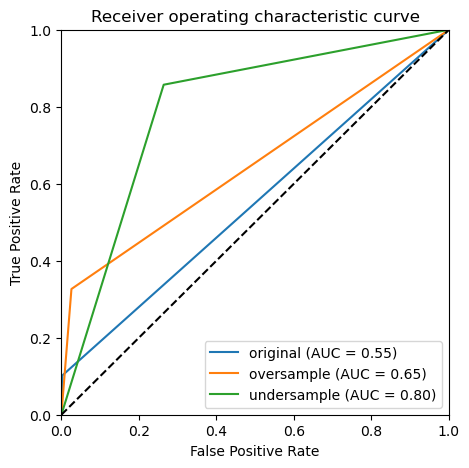

In [31]:
# 평가지표
evaluate_model(y_4_val, [rnf_orign_class_4_pred, rnf_ros_class_4_pred, rnf_rus_class_4_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[1203   32]
 [  33   16]]


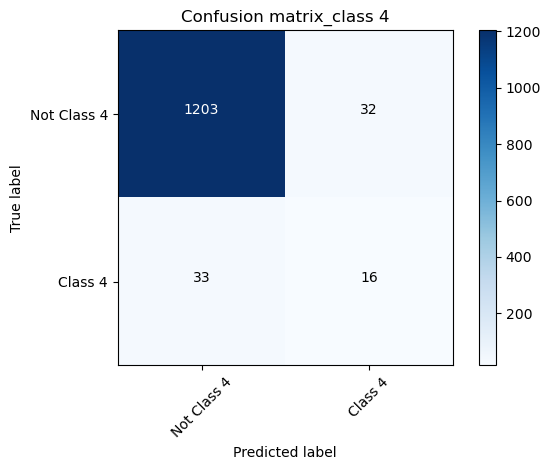

In [32]:
# 클래스의 이름을 정의
class_names = ['Not Class 4', 'Class 4']
cm = confusion_matrix(y_4_val, rnf_ros_class_4_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix_class 4')
plt.show()

original Feature Importances
                 feature  importances
2       volatile acidity     0.129968
6    free sulfur dioxide     0.111207
7   total sulfur dioxide     0.098412
4         residual sugar     0.091189
8                density     0.087475
5              chlorides     0.080724
10             sulphates     0.080592
9                     pH     0.077785
1          fixed acidity     0.077776
3            citric acid     0.076589
11               alcohol     0.075975
0                   type     0.012309
oversample Feature Importances
                 feature  importances
6    free sulfur dioxide     0.185489
7   total sulfur dioxide     0.123523
2       volatile acidity     0.098912
10             sulphates     0.096466
11               alcohol     0.082995
5              chlorides     0.080006
4         residual sugar     0.076027
1          fixed acidity     0.062666
9                     pH     0.056733
8                density     0.055007
3            citric acid    

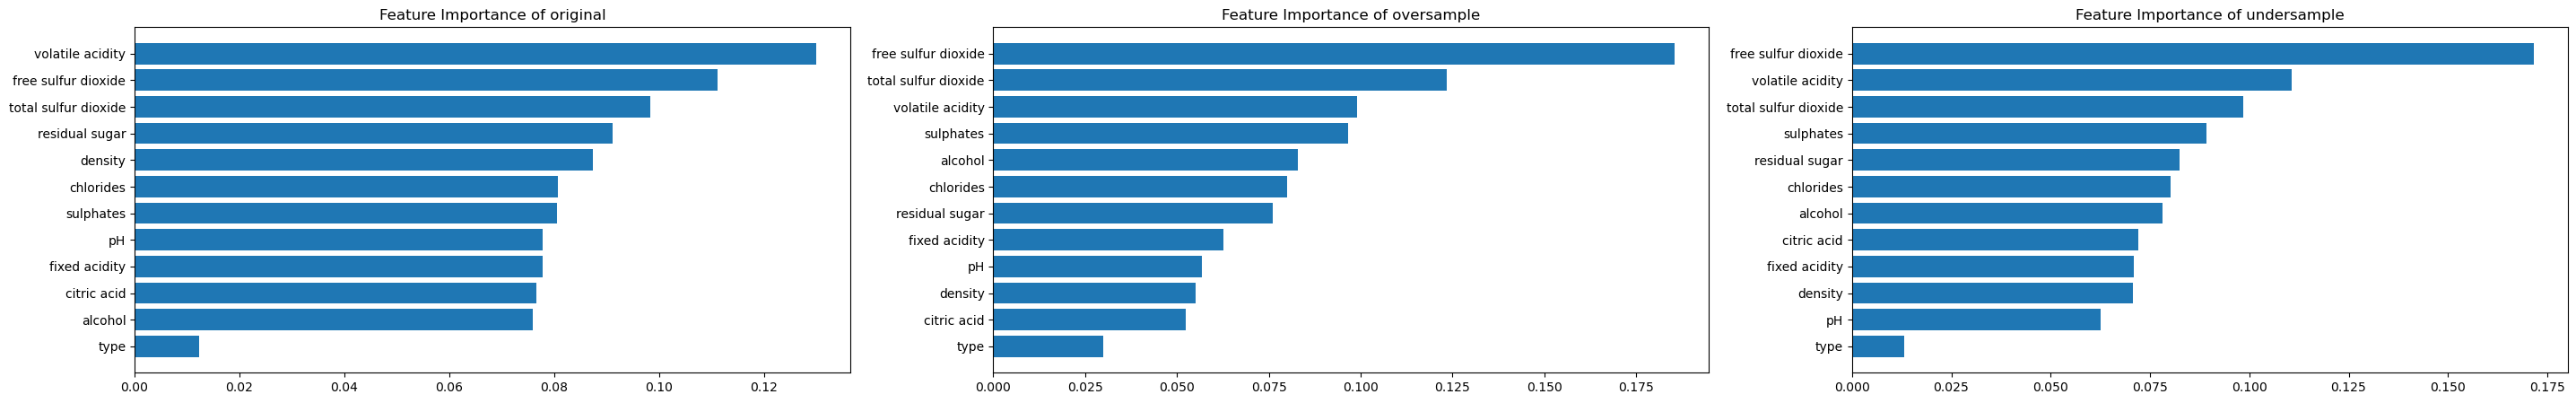

In [33]:
# feature importance
feature_importance(X_4_val, y_4_val, [model_rnf_orign_class_4, model_rnf_ros_class_4, model_rnf_rus_class_4], ['original', 'oversample', 'undersample'])

### 4.3.1 y_5

In [34]:
# y_5 Grid Search (f1 score / default_F)
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 100}
# orign data result:  0.6633756769922452
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 100}
# ros data result:  0.8377755042868029
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 300, 'random_state': 100}
# rus data result:  0.7720435670973796
# -------------------------------------------------------------------------------------------------------------------

In [35]:
# 하이퍼파라미터 설정
model_rnf_orign_class_5 = RandomForestClassifier(max_depth=20, min_samples_leaf=1, n_estimators=200, random_state=100)
model_rnf_ros_class_5 = RandomForestClassifier(max_depth=30, min_samples_leaf=1, n_estimators=300, random_state=100)
model_rnf_rus_class_5 = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300, random_state=100)



# 모델 학습
model_rnf_orign_class_5.fit(X_5_train, y_5_train)
model_rnf_ros_class_5.fit(X_5_train_ros, y_5_train_ros)
model_rnf_rus_class_5.fit(X_5_train_rus, y_5_train_rus)

# 모델 예측
rnf_orign_class_5_pred = model_rnf_orign_class_5.predict(X_5_val)
rnf_ros_class_5_pred = model_rnf_ros_class_5.predict(X_5_val)
rnf_rus_class_5_pred = model_rnf_rus_class_5.predict(X_5_val)
print(rnf_orign_class_5_pred)
print(rnf_ros_class_5_pred)
print(rnf_rus_class_5_pred)

[0. 0. 1. ... 0. 0. 1.]
[0. 1. 1. ... 0. 0. 1.]
[0. 1. 1. ... 0. 1. 1.]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.8146   |   0.7218   |   0.6566   |   0.6877   |   0.7713  
  oversample    |   0.8115   |   0.6725   |   0.7669   |   0.7166   |   0.7993  
  undersample   |   0.7788   |   0.6055   |   0.8271   |   0.6992   |   0.7921  
--------------------------------------------------------------------------------


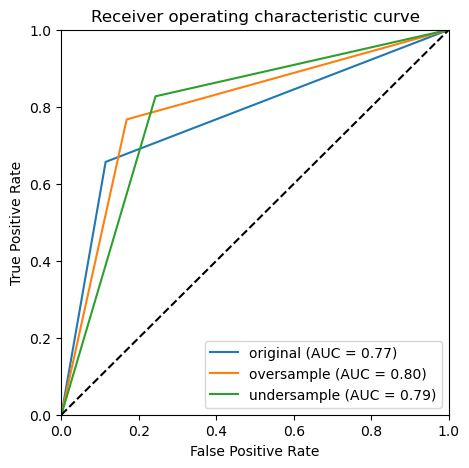

In [36]:
# 평가지표
evaluate_model(y_5_val, [rnf_orign_class_5_pred, rnf_ros_class_5_pred, rnf_rus_class_5_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[736 149]
 [ 93 306]]


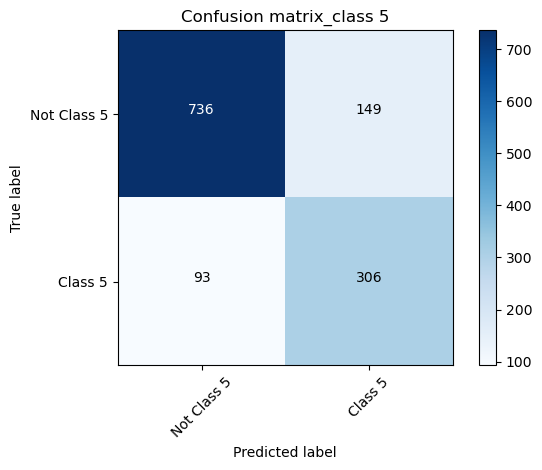

In [44]:
# 클래스의 이름을 정의
class_names = ['Not Class 5', 'Class 5']
cm = confusion_matrix(y_5_val, rnf_ros_class_5_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix_class 5')
plt.show()

original Feature Importances
                 feature  importances
11               alcohol     0.161501
8                density     0.104431
2       volatile acidity     0.103056
5              chlorides     0.087308
7   total sulfur dioxide     0.084973
3            citric acid     0.079473
4         residual sugar     0.077809
10             sulphates     0.075288
9                     pH     0.075137
6    free sulfur dioxide     0.074611
1          fixed acidity     0.071889
0                   type     0.004524
oversample Feature Importances
                 feature  importances
11               alcohol     0.186228
8                density     0.110895
2       volatile acidity     0.108465
5              chlorides     0.087186
10             sulphates     0.078023
7   total sulfur dioxide     0.075119
6    free sulfur dioxide     0.072037
3            citric acid     0.070266
9                     pH     0.068732
4         residual sugar     0.067037
1          fixed acidity    

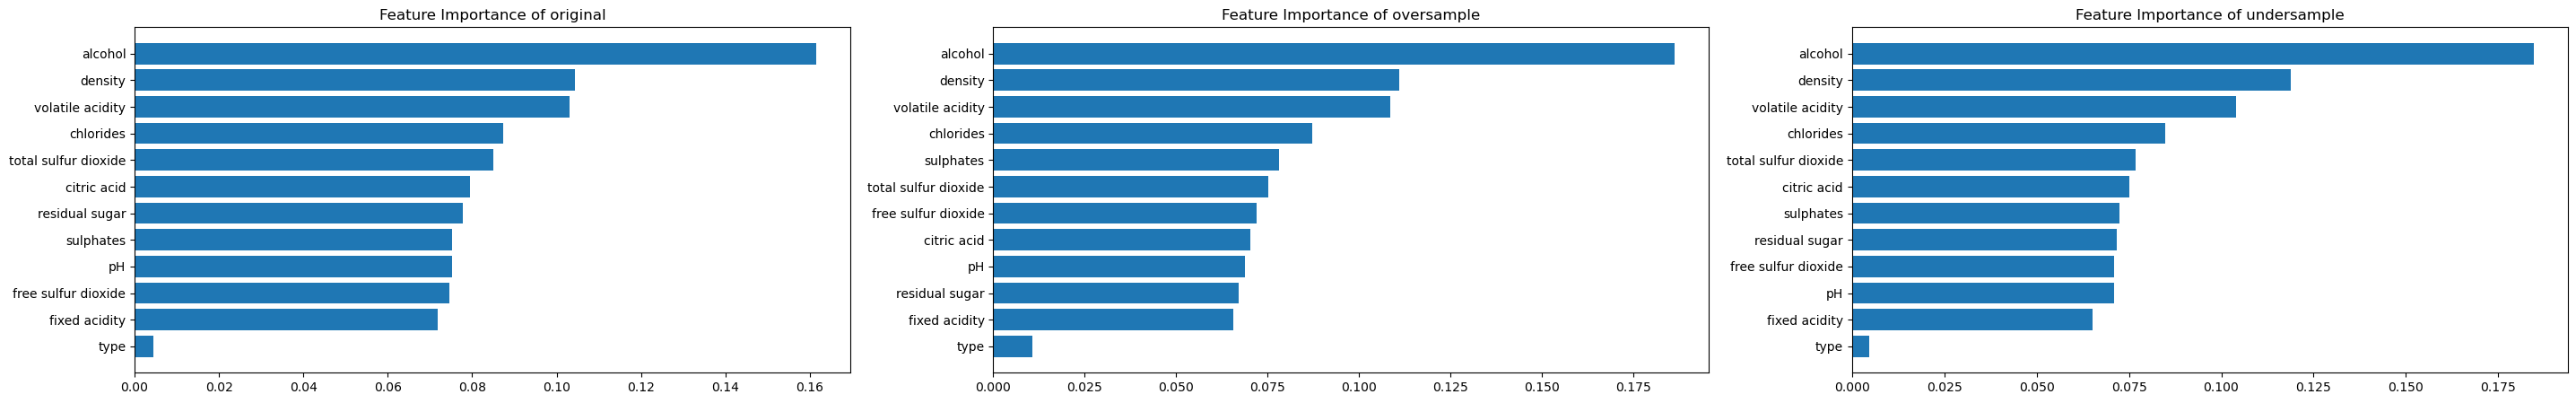

In [35]:
# feature importance
feature_importance(X_5_val, y_5_val, [model_rnf_orign_class_5, model_rnf_ros_class_5, model_rnf_rus_class_5], ['original', 'oversample', 'undersample'])

### 4.3.1 y_6

In [38]:
# y_6 Grid Search (f1 score / default_F)
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 200, 'random_state': 100}
# orign data result:  0.6122830005817199
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 300, 'random_state': 100}
# ros data result:  0.7228140917492347
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 100}
# rus data result:  0.6811453597471635
# -------------------------------------------------------------------------------------------------------------------


In [39]:
# 하이퍼파라미터 설정
model_rnf_orign_class_6 = RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=200, random_state=100)
model_rnf_ros_class_6 = RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=300, random_state=100)
model_rnf_rus_class_6 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=200, random_state=100)

# 모델 학습
model_rnf_orign_class_6.fit(X_6_train, y_6_train)
model_rnf_ros_class_6.fit(X_6_train_ros, y_6_train_ros)
model_rnf_rus_class_6.fit(X_6_train_rus, y_6_train_rus)

# 모델 예측
rnf_orign_class_6_pred = model_rnf_orign_class_6.predict(X_6_val)
rnf_ros_class_6_pred = model_rnf_ros_class_6.predict(X_6_val)
rnf_rus_class_6_pred = model_rnf_rus_class_6.predict(X_6_val)
print(rnf_orign_class_6_pred)
print(rnf_ros_class_6_pred)
print(rnf_rus_class_6_pred)

[1. 1. 0. ... 1. 0. 0.]
[1. 1. 0. ... 1. 1. 0.]
[1. 1. 0. ... 1. 1. 0.]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.7064   |   0.6830   |   0.6188   |   0.6493   |   0.6969  
  oversample    |   0.7142   |   0.6690   |   0.6915   |   0.6800   |   0.7117  
  undersample   |   0.6690   |   0.6003   |   0.7376   |   0.6619   |   0.6764  
--------------------------------------------------------------------------------


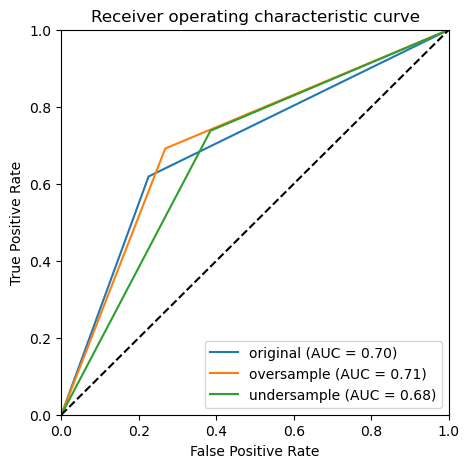

In [40]:
# 평가지표
evaluate_model(y_6_val, [rnf_orign_class_6_pred, rnf_ros_class_6_pred, rnf_rus_class_6_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[527 193]
 [174 390]]


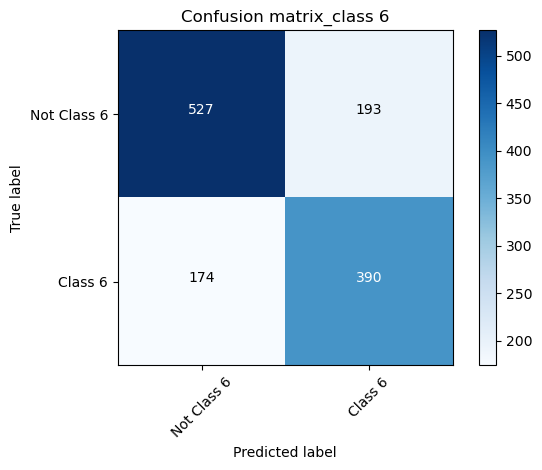

In [43]:
# 클래스의 이름을 정의
class_names = ['Not Class 6', 'Class 6']
cm = confusion_matrix(y_6_val, rnf_ros_class_6_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix_class 6')
plt.show()

original Feature Importances
                 feature  importances
2       volatile acidity     0.099308
11               alcohol     0.097817
7   total sulfur dioxide     0.097186
8                density     0.096901
10             sulphates     0.090486
4         residual sugar     0.089891
6    free sulfur dioxide     0.089604
5              chlorides     0.088588
9                     pH     0.085229
3            citric acid     0.082263
1          fixed acidity     0.079774
0                   type     0.002954
oversample Feature Importances
                 feature  importances
11               alcohol     0.102976
2       volatile acidity     0.101186
7   total sulfur dioxide     0.098027
8                density     0.091783
6    free sulfur dioxide     0.091236
10             sulphates     0.091151
4         residual sugar     0.087932
5              chlorides     0.085893
9                     pH     0.083533
3            citric acid     0.081628
1          fixed acidity    

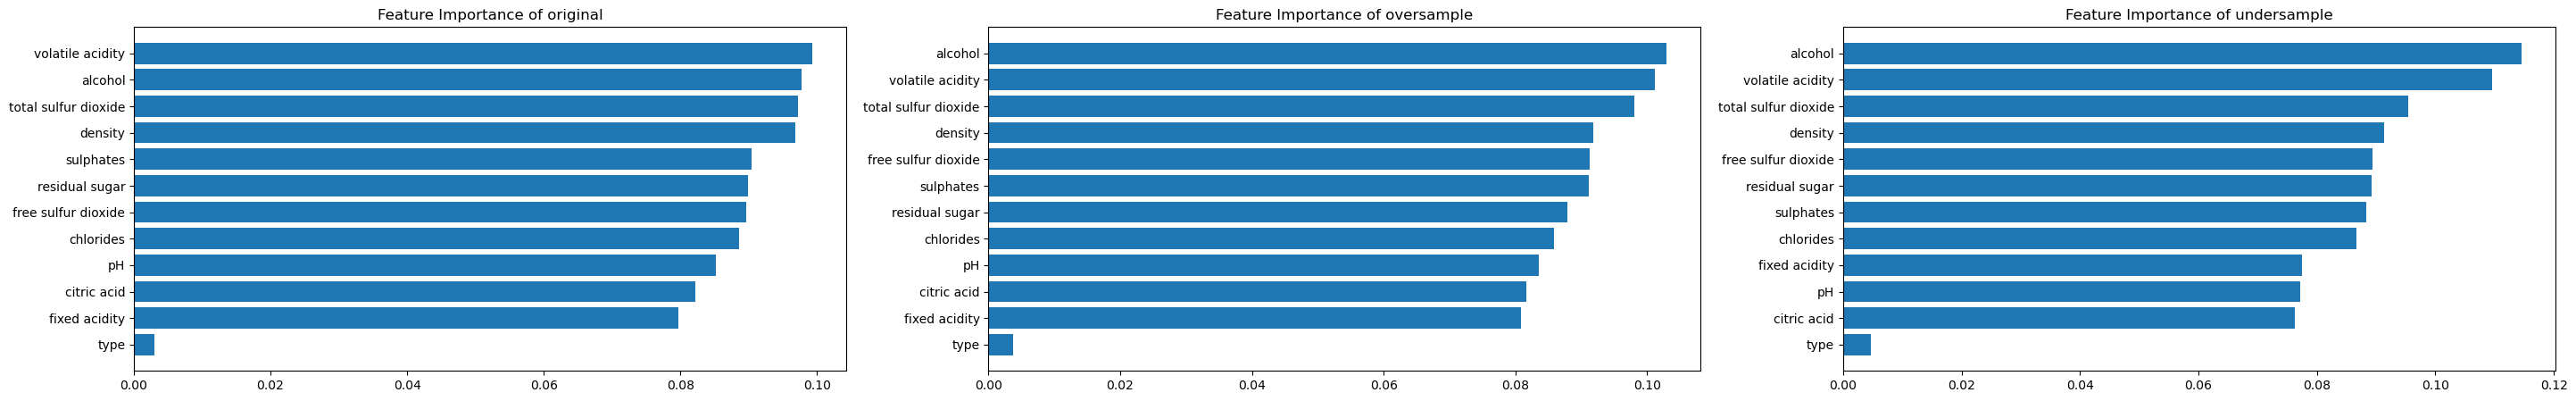

In [45]:
# feature importance
feature_importance(X_6_val, y_6_val, [model_rnf_orign_class_6, model_rnf_ros_class_6, model_rnf_rus_class_6], ['original', 'oversample', 'undersample'])

### 4.3.1 y_7

In [46]:
# y_7 Grid Search (f1 score / default_F)
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
# orign data result:  0.4870138821279772
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 100}
# ros data result:  0.9139443502598394
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 100}
# rus data result:  0.7967096110352798
# -------------------------------------------------------------------------------------------------------------------


In [47]:
# 하이퍼파라미터 설정
model_rnf_orign_class_7 = RandomForestClassifier(max_depth=30, min_samples_leaf=1, n_estimators=100, random_state=100)
model_rnf_ros_class_7 = RandomForestClassifier(max_depth=30, min_samples_leaf=1, n_estimators=200, random_state=100)
model_rnf_rus_class_7 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=300, random_state=100)

# 모델 학습
model_rnf_orign_class_7.fit(X_7_train, y_7_train)
model_rnf_ros_class_7.fit(X_7_train_ros, y_7_train_ros)
model_rnf_rus_class_7.fit(X_7_train_rus, y_7_train_rus)

# 모델 예측
rnf_orign_class_7_pred = model_rnf_orign_class_7.predict(X_7_val)
rnf_ros_class_7_pred = model_rnf_ros_class_7.predict(X_7_val)
rnf_rus_class_7_pred = model_rnf_rus_class_7.predict(X_7_val)
print(rnf_orign_class_7_pred)
print(rnf_ros_class_7_pred)
print(rnf_rus_class_7_pred)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 1. 0.]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.8762   |   0.8053   |   0.3991   |   0.5337   |   0.6891  
  oversample    |   0.8598   |   0.5968   |   0.6491   |   0.6218   |   0.7772  
  undersample   |   0.7407   |   0.3895   |   0.8114   |   0.5263   |   0.7684  
--------------------------------------------------------------------------------


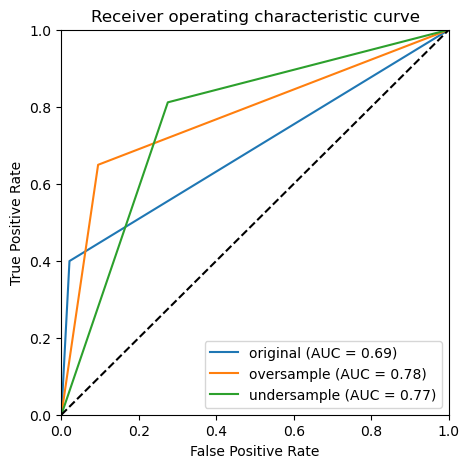

In [48]:
# 평가지표
evaluate_model(y_7_val, [rnf_orign_class_7_pred, rnf_ros_class_7_pred, rnf_rus_class_7_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[956 100]
 [ 80 148]]


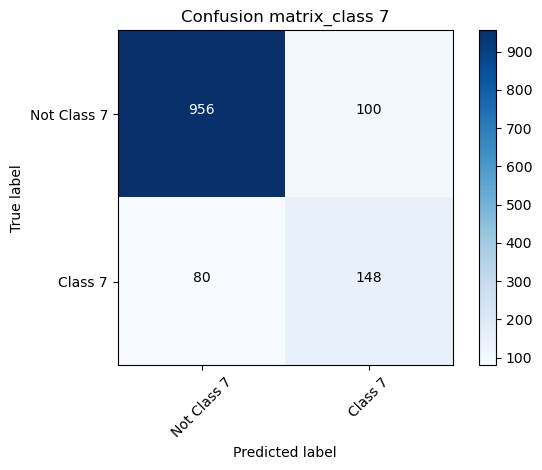

In [49]:
# 클래스의 이름을 정의
class_names = ['Not Class 7', 'Class 7']
cm = confusion_matrix(y_7_val, rnf_ros_class_7_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix_class 7')
plt.show()

original Feature Importances
                 feature  importances
11               alcohol     0.143341
8                density     0.114633
2       volatile acidity     0.089057
5              chlorides     0.089032
7   total sulfur dioxide     0.087371
4         residual sugar     0.084037
9                     pH     0.083379
10             sulphates     0.082989
3            citric acid     0.077338
6    free sulfur dioxide     0.077011
1          fixed acidity     0.069700
0                   type     0.002112
oversample Feature Importances
                 feature  importances
11               alcohol     0.196398
2       volatile acidity     0.095547
8                density     0.094543
5              chlorides     0.083347
7   total sulfur dioxide     0.082966
4         residual sugar     0.080020
3            citric acid     0.079729
10             sulphates     0.075509
1          fixed acidity     0.072003
6    free sulfur dioxide     0.070307
9                     pH    

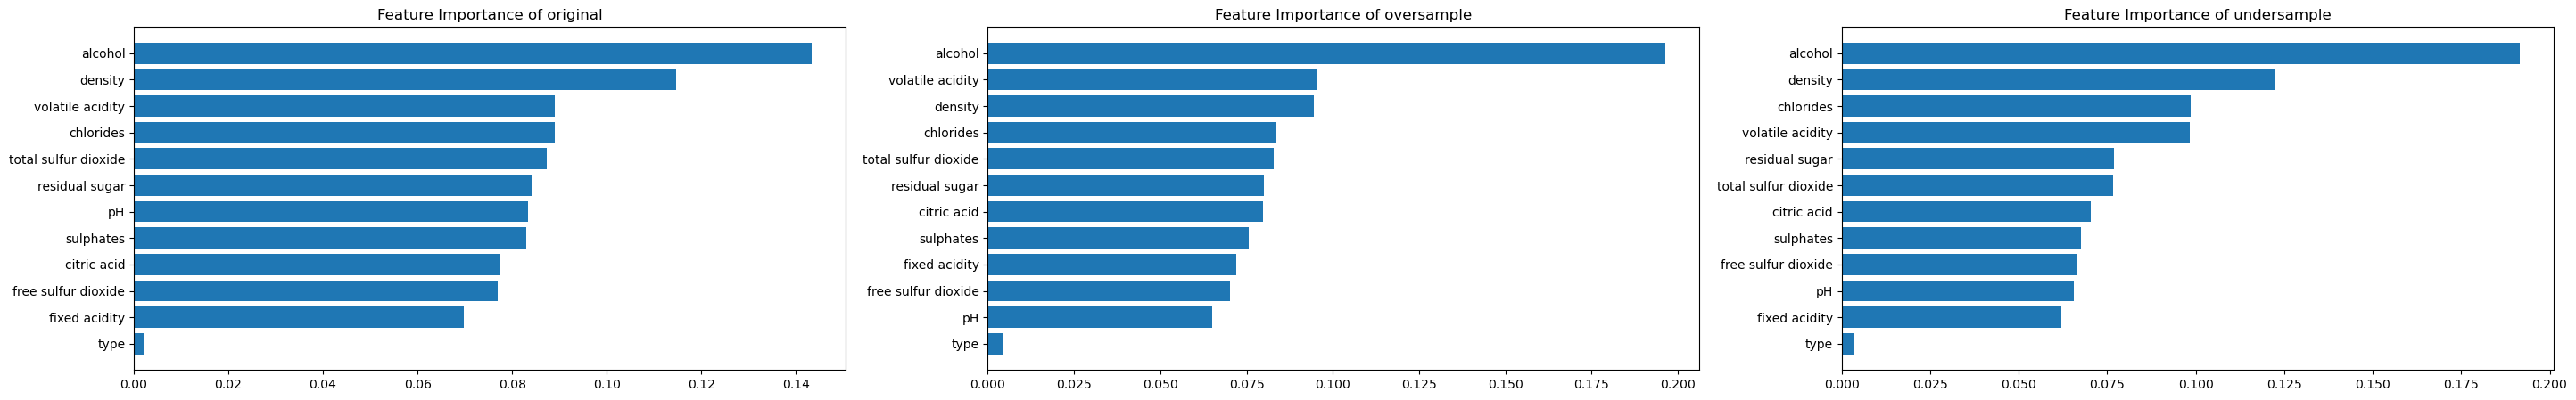

In [50]:
# feature importance
feature_importance(X_7_val, y_7_val, [model_rnf_orign_class_7, model_rnf_ros_class_7, model_rnf_rus_class_7], ['original', 'oversample', 'undersample'])

### 4.3.1 y_8

In [51]:
# y_8 Grid Search (f1 score / default_F)
# -------------------------------------------------------------------------------------------------------------------
# orign data result:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
# orign data result:  0.30404395604395607
# -------------------------------------------------------------------------------------------------------------------
# ros data result:  {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 100}
# ros data result:  0.9802189224389537
# -------------------------------------------------------------------------------------------------------------------
# rus data result:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 100}
# rus data result:  0.8308390022675738
# -------------------------------------------------------------------------------------------------------------------

In [52]:
# 하이퍼파라미터 설정
model_rnf_orign_class_8 = RandomForestClassifier(max_depth=20, min_samples_leaf=1, n_estimators=100, random_state=100)
model_rnf_ros_class_8 = RandomForestClassifier(max_depth=30, min_samples_leaf=1, n_estimators=100, random_state=100)
model_rnf_rus_class_8 = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=200, random_state=100)

# 모델 학습
model_rnf_orign_class_8.fit(X_8_train, y_8_train)
model_rnf_ros_class_8.fit(X_8_train_ros, y_8_train_ros)
model_rnf_rus_class_8.fit(X_8_train_rus, y_8_train_rus)

# 모델 예측
rnf_orign_class_8_pred = model_rnf_orign_class_8.predict(X_8_val)
rnf_ros_class_8_pred = model_rnf_ros_class_8.predict(X_8_val)
rnf_rus_class_8_pred = model_rnf_rus_class_8.predict(X_8_val)
print(rnf_orign_class_8_pred)
print(rnf_ros_class_8_pred)
print(rnf_rus_class_8_pred)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


                |  Accuracy  | Precision  |   Recall   |  F1-score  |    AUC    
--------------------------------------------------------------------------------
   original     |   0.9774   |   1.0000   |   0.3409   |   0.5085   |   0.6705  
  oversample    |   0.9564   |   0.3696   |   0.3864   |   0.3778   |   0.6815  
  undersample   |   0.7516   |   0.1060   |   0.8409   |   0.1883   |   0.7946  
--------------------------------------------------------------------------------


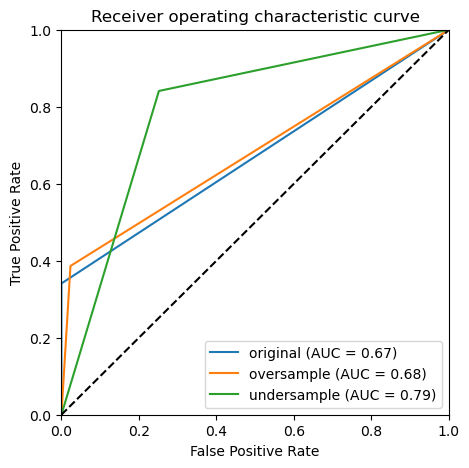

In [53]:
# 평가지표
evaluate_model(y_8_val, [rnf_orign_class_8_pred, rnf_ros_class_8_pred, rnf_rus_class_8_pred], ['original', 'oversample', 'undersample'])

Confusion matrix, without normalization
[[1240    0]
 [  29   15]]


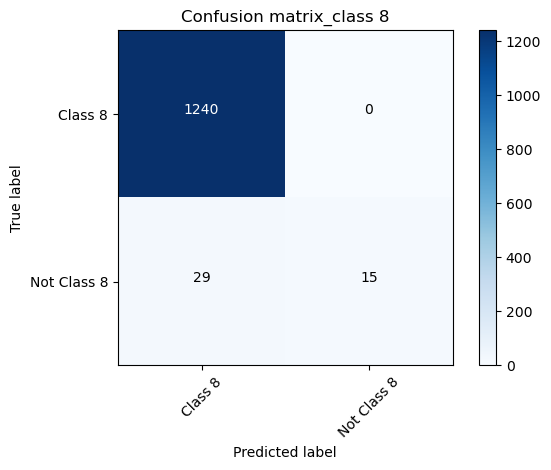

In [55]:
# 클래스의 이름을 정의
class_names = ['Class 8', 'Not Class 8']
cm = confusion_matrix(y_8_val, rnf_orign_class_8_pred)

# 혼동행렬 그래프 출력
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix_class 8')
plt.show()

original Feature Importances
                 feature  importances
11               alcohol     0.103606
8                density     0.102742
4         residual sugar     0.102616
10             sulphates     0.095331
6    free sulfur dioxide     0.095112
7   total sulfur dioxide     0.092011
2       volatile acidity     0.091336
5              chlorides     0.084437
1          fixed acidity     0.080022
9                     pH     0.077953
3            citric acid     0.072788
0                   type     0.002047
oversample Feature Importances
                 feature  importances
11               alcohol     0.244406
6    free sulfur dioxide     0.099364
2       volatile acidity     0.085814
5              chlorides     0.085154
8                density     0.082864
7   total sulfur dioxide     0.074991
4         residual sugar     0.074674
1          fixed acidity     0.067458
3            citric acid     0.062097
9                     pH     0.060604
10             sulphates    

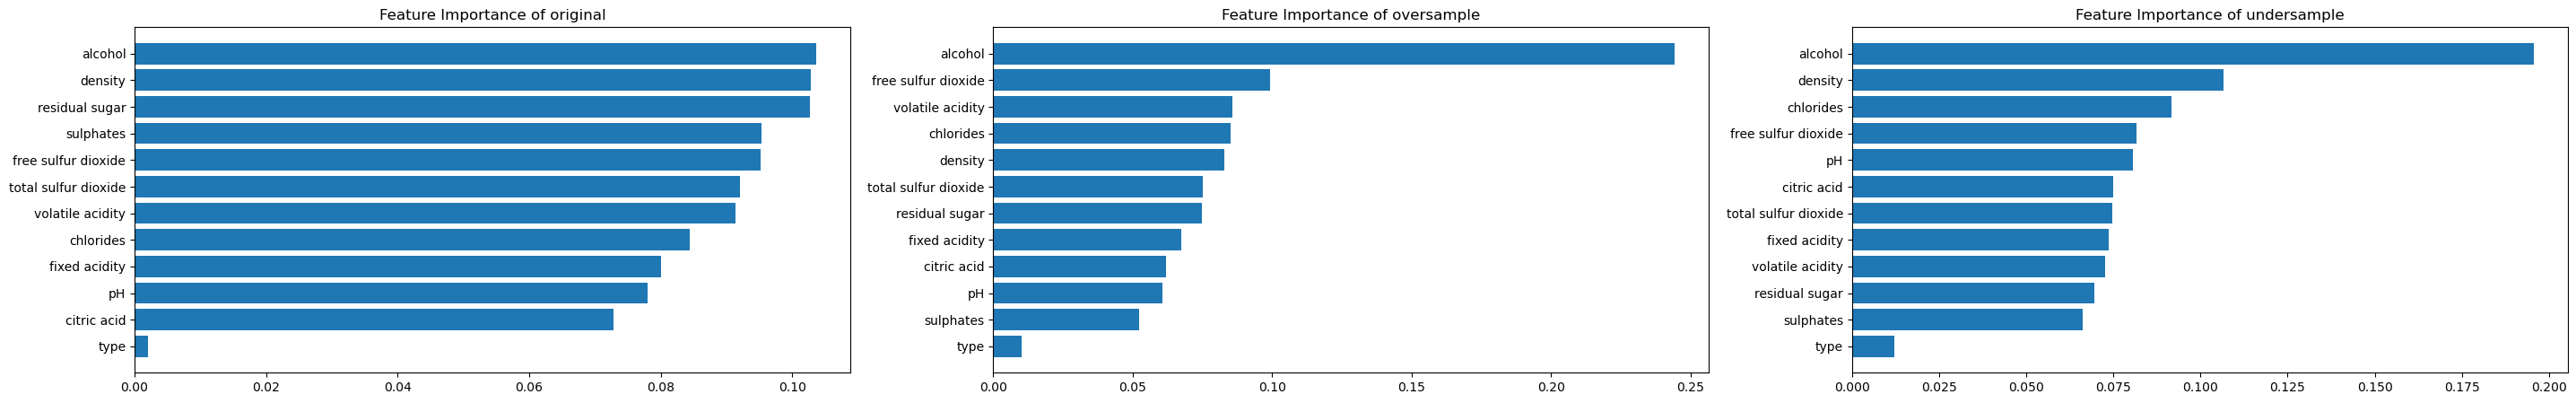

In [56]:
# feature importance
feature_importance(X_8_val, y_8_val, [model_rnf_orign_class_8, model_rnf_ros_class_8, model_rnf_rus_class_8], ['original', 'oversample', 'undersample'])

# 5. Model Selection 및 trained model 저장

In [57]:
# f1 score가 높은 모델을 선출
# class_4 : model_rnf_ros_class_4
# class_5 : model_rnf_ros_class_5
# class_6 : model_rnf_ros_class_6
# class_7 : model_rnf_ros_class_7
# class_8 : model_rnf_orign_class_8

In [58]:
import joblib

joblib.dump(model_rnf_ros_class_4, './model_rnf_over_class_4.joblib')
joblib.dump(model_rnf_ros_class_5, './model_rnf_over_class_5.joblib')
joblib.dump(model_rnf_ros_class_6, './model_rnf_over_class_6.joblib')
joblib.dump(model_rnf_ros_class_7, './model_rnf_over_class_7.joblib')
joblib.dump(model_rnf_orign_class_8, './model_rnf_orign_class_8.joblib')

['./model_rnf_orign_class_8.joblib']